In [1]:
# CSVファイルに記載したフォルダ・PDFファイル名を読み込み、
# PDFファイルのテキストの属性情報をinfoフォルダに格納

import pandas as pd
import numpy as np
import MeCab
import fitz
import re
import sys
sys.path.append('/work_dir') 
import talknize_module_20240909 as tk
import csv
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


In [2]:
import logging

# ログファイルの設定
log_filename = "data/logfile.log"
logging.basicConfig(
    level=logging.INFO,  # ログレベルの設定 (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(levelname)s - %(message)s",  # ログのフォーマット
    handlers=[
        logging.FileHandler(log_filename, mode="a", encoding="utf-8"),  # ファイルに記録
        #logging.StreamHandler()  # コンソールにも出力
    ]
)


In [3]:
import fitz  # PyMuPDF
import pandas as pd

def extract_pdf_attributes(pdf_path, page_number, output_csv_path):
    """
    指定したPDFファイルのブロック・ライン・スパン単位でデータ属性を取得し、CSV形式で出力。
    
    Args:
        pdf_path (str): PDFファイルのパス。
        page_number (int): ページ番号（1から始まる）。
        output_csv_path (str): 出力するCSVファイルのパス。
        
    Returns:
        pd.DataFrame: 取得したデータ属性を保持するデータフレーム。
    """
    try:
        # PDFを開く
        doc = fitz.open(pdf_path)
        
        # ページ番号が正しいか確認
        if page_number < 1 or page_number > len(doc):
            print(f"エラー: ページ番号は1から{len(doc)}の間で指定してください。")
            logging.error(f"エラー: ページ番号は1から{len(doc)}の間で指定してください。")
            return None
        
        # 対象ページを取得（0インデックス）
        page = doc[page_number - 1]
        
        # ページ内のブロックを取得
        blocks = page.get_text("dict")["blocks"]
        
        # データ保持用リスト
        data = []
        
        for block_no, block in enumerate(blocks, start=1):
            if "lines" not in block:
                continue  # ブロックに行がない場合はスキップ
            
            for line_no, line in enumerate(block["lines"], start=1):
                if "spans" not in line:
                    continue  # 行にスパンがない場合はスキップ
                
                for span_no, span in enumerate(line["spans"], start=1):
                    # 各スパンの属性を取得
                    text = span.get("text", "")
                    bbox = line["bbox"]
                    font = span.get("font", "")
                    size = span.get("size", "")
                    color = span.get("color", "")
                    text_type = span.get("flags", "")
                    origin = span.get("origin", (None, None))  # originを取得
                    ascender = span.get("ascender", None)      # ascenderを取得
                    
                    # データをリストに追加
                    data.append({
                        "page_no": page_number,
                        "block_no": block_no,
                        "line_no": line_no,
                        "span_no": span_no,
                        "text": text,
                        "origin_x": origin[0],
                        "origin_y": origin[1],
                        "bbox_x0": bbox[0],
                        "bbox_y0": bbox[1],
                        "bbox_x1": bbox[2],
                        "bbox_y1": bbox[3],
                        "font": font,
                        "size": size,
                        "color": color,
                        "text_type": text_type,
                        "ascender": ascender,
                    })
        
        # PDFを閉じる
        doc.close()
        
        # pandasデータフレームに変換
        df = pd.DataFrame(data)
        
        # CSVとして出力
        df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")
        #print(f"ターゲットページの属性情報がCSVに出力されました: {output_csv_path}")
        logging.info(f"ターゲットページの属性情報がCSVに出力されました: {output_csv_path}")
        return df
 
    except Exception as e:
        print(f"extract_pdf_attributesでエラーが発生しました: {e}")
        logging.error(f"extract_pdf_attributesでエラーが発生しました: {e}")
        return None


In [4]:
# CSVを読み込む関数
def load_csv(file_path):
    """
    CSVを読み込み、DataFrameを返す
    file_path: CSVファイルのパス
    """
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: CSV file not found at {file_path}")
        logging.error(f"Error: CSV file not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: CSV file at {file_path} is empty or invalid")
        logging.error(f"Error: CSV file at {file_path} is empty or invalid")
        return None
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        logging.error(f"Error reading CSV file: {e}")
        return None

In [5]:
#全頁からブロックの属性情報を抽出・データフレームに格納

def extract_blocks_from_pdf(pdf_path):
    pdf_doc = fitz.open(pdf_path)
    data = []

    # 各ページからデータ抽出
    for page_num in range(len(pdf_doc)):
        page = pdf_doc[page_num]
        blocks = page.get_text("dict")["blocks"]
        for block in blocks:
            block_bbox = block["bbox"]
            for line in block.get("lines", []):
                line_text = " ".join([span["text"] for span in line["spans"]])
                line_bbox = line["bbox"]
                data.append({
                    "page": page_num + 1,
                    "x0": line_bbox[0],
                    "y0": line_bbox[1],
                    "x1": line_bbox[2],
                    "y1": line_bbox[3],
                    "text": line_text.strip()
                })
    pdf_doc.close()
    return pd.DataFrame(data)

In [6]:
#データフレームに格納された（全ページの）属性情報からヘッダ・フッタ候補を抽出、同一内容のものを集約し件数をカウント

def identify_header_footer(data, threshold=40):
    # ページごとの y0 値の分布を取得
    headers = []
    footers = []

    for page_num, group in data.groupby("page"):
        y0_values = group["y0"].values
        if len(y0_values) == 0:
            continue

        min_y0, max_y0 = np.min(y0_values), np.max(y0_values)

        # ヘッダ候補: y0 が分布の下位 (小さい値)
        header_candidates = group[np.abs(group["y0"] - min_y0) < threshold]
        headers.append(header_candidates)

        # フッタ候補: y0 が分布の上位 (大きい値)
        footer_candidates = group[np.abs(group["y0"] - max_y0) < threshold]
        footers.append(footer_candidates)

    # ヘッダ・フッタを統合
    headers = pd.concat(headers, ignore_index=True)
    footers = pd.concat(footers, ignore_index=True)

    # 頻出パターンを確認 (x0, y0, text を基準にグループ化)
    header_patterns = headers.groupby(["x0", "y0", "text"]).size().reset_index(name="count")
    footer_patterns = footers.groupby(["x0", "y0", "text"]).size().reset_index(name="count")

    return header_patterns, footer_patterns


In [10]:
# メインルーチン

def main():
    # CSVファイルのパス
    csv_path = 'data/Attrib_Analysis_Target_20250114_test.csv'  # CSVのパスを指定

    # CSVを読み込む
    df_target = load_csv(csv_path)
    if df_target is None:
        print("Failed to load CSV. Exiting program.")
        logging.error("Failed to load CSV. Exiting program.")
        return

    # 必要な列名を指定
    folder_col = '格納フォルダ'
    file_col = '統合報告書PDF'
    target_col = 'target_page'

    # CSVに必要な列がなければエラー表示
    if folder_col not in df_target.columns or file_col not in df_target.columns or target_col not in df_target.columns:
        print(f"Error: CSV file must contain '{folder_col}' and '{file_col}' and '{target_page}' columns")
        logging.error(f"Error: CSV file must contain '{folder_col}' and '{file_col}' and '{target_page}' columns")
        return

    # リストの企業ごとに、ターゲットページ（のみ）の属性情報を取得・処理・保存
    #file_paths = []
    for index, row in df_target.iterrows():

        #================================================================
        #前処理（フォルダの確認・パス名の定義　等）
        folder_name = 'ir/2025/' + row[folder_col]
        file_name = row[file_col]
        target_page = row[target_col]

        # パスが有効かチェック
        #　file_pathを作成してfile_pathsにリストとして追記・保存するが、必要情報がない場合は''としておく
        if pd.isna(folder_name) or pd.isna(file_name):
            print(f"Skipping row {index}: Folder or File is missing")
            logging.warning(f"Skipping row {index}: Folder or File is missing")
            file_path =''
            return

        print(f"==== Processing {folder_name}/{file_name} ====")
        logging.info(f"==== Processing {folder_name}/{file_name} ====")

        #属性情報を格納するフォルダ（info）の有無を確認、なければ作成
        info_file_path = folder_name + '/' + 'info'
        if not os.path.exists(info_file_path):
            os.makedirs(info_file_path)

        #================================================================
        #属性情報の保存・データフレームへの格納
        # file_path（対象PDF）を生成 
        file_path = folder_name + '/' + file_name
        #file_path = os.path.join(folder_name, file_name)
        #file_paths.append(file_path)

        #属性情報を格納するcsvファイルのパスを作成
        output_file_path = info_file_path + '/' +file_name[:len(file_name)-4] + "_attrib_page" + str(target_page) + ".csv"

        # 属性情報を抽出し、CSVfファイルに出力の上、以降の作業用にデータフレームdf_attribに格納
        df_attrib = extract_pdf_attributes(file_path, target_page, output_file_path)
        #print(df_attrib)
    
        #================================================================
        #テキストボックスの始点座標のプロット（ブロック番号付き）
        # line_no=1 のデータを抽出
        plot_data = df_attrib

        # bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_data['bbox_x0'], plot_data['bbox_y0'], alpha=0.7, s=10)
        
        # block_no を各点に表示
        for x, y, block_no in zip(plot_data['bbox_x0'], plot_data['bbox_y0'], plot_data['block_no']):
            plt.text(x, y, str(block_no), fontsize=8, ha='right', va='bottom')  # block_no をラベルとして表示
        
        plt.title('Scatter Plot of box_x0 vs bbox_y0 with block_no', fontsize=14)
        plt.xlabel('bbox_x0', fontsize=12)
        plt.ylabel('bbox_y0 (Inverted)', fontsize=12)
        plt.gca().invert_yaxis()  # Y軸を上下反転
        plt.grid(alpha=0.3)
        
        # プロットを保存
        plot_file_path = info_file_path + '/' +file_name[:len(file_name)-4] + '_' +str(target_page) + ".png"
        # DPIを設定し保存
        plt.savefig(plot_file_path, dpi=300, bbox_inches='tight')  
        # プロットを表示
        #plt.show()
        # プロットを閉じる（これにより画面に表示されない）
        plt.close()
        #print(f"プロットが保存されました: {plot_file_path}")
        logging.info(f"プロットが保存されました: {plot_file_path}")

        #================================================================
        #　上下左右のマージン検討・設定時に参照するブロックのxy座標及びテキスト情報をファイルに格納

        n_write = 40
        print_flag = False

        # ヘッダ候補（y1）・フッタ候補（y0）.・左マージン候補（x0）・右マージン候補（x1）を作成
        sorted_y1 = df_attrib.sort_values(by='bbox_y1', ascending=True)[['block_no', 'bbox_y1', 'text']]
        sorted_y0 = df_attrib.sort_values(by='bbox_y0', ascending=False)[['block_no', 'bbox_y0', 'text']]
        sorted_x1 = df_attrib.sort_values(by='bbox_x1', ascending=True)[['block_no', 'bbox_x1', 'text']]
        sorted_x0 = df_attrib.sort_values(by='bbox_x0', ascending=False)[['block_no', 'bbox_x0', 'text']]

        #画面表示用
        if print_flag == True:
            print("=== bbox(y1) for Header ===")
            print(sorted_y1)
            print()
            print("=== bbox(y0) for Footer ===")
            print(sorted_y0)
            print()
            print("=== bbox(x0) for Left Margin ===")
            print(sorted_x0)
            print()
            print("=== bbox(x0) for Right Margin ===")
            print(sorted_x1)
        
        output_file_path = info_file_path  + "/" + "Margin_Candidate_list_page-" + str(target_page) + ".txt"
        
        # ヘッダ候補（y1）・フッタ候補（y0）.・左マージン候補（x0）・右マージン候補（x1）をテキストファイルに書き出す
        with open(output_file_path, "w", encoding="utf-8") as file:
            file.write("=== bbox(y1) for Header ===\n")
            for _, row in sorted_y1.head(n_write).iterrows():
                # 'text'列を左寄せに整形して保存
                file.write(f"{row['block_no']}\t{row['bbox_y1']:.2f}\t{row['text']}\n")
            file.write("\n\n")  
            file.write("=== bbox(y0) for Footer ===\n")
            for _, row in sorted_y0.head(n_write).iterrows():
                # 'text'列を左寄せに整形して保存
                file.write(f"{row['block_no']}\t{row['bbox_y0']:.2f}\t{row['text']}\n")
            file.write("\n\n")  
            file.write("=== bbox(x0) for Left Margin ===\n")
            for _, row in sorted_x1.head(n_write).iterrows():
                # 'text'列を左寄せに整形して保存
                file.write(f"{row['block_no']}\t{row['bbox_x1']:.2f}\t{row['text']}\n")
            file.write("\n\n")  
            file.write("=== bbox(x0) for Right Margin ===\n")
            for _, row in sorted_x0.head(n_write).iterrows():
                # 'text'列を左寄せに整形して保存
                file.write(f"{row['block_no']}\t{row['bbox_x0']:.2f}\t{row['text']}\n")

        #=============================================
        #以降はターゲットページのみではなく、各社の全頁からデータ取得、候補情報を集計
        #全頁を読み込み、処理するため、かなり負荷がかかるはず
        # PDFデータを抽出
        df_pdf_all_pages = extract_blocks_from_pdf(file_path)
    
        # ヘッダ・フッタを識別
        headers, footers = identify_header_footer(df_pdf_all_pages)
    
        # 結果をソートして表示
        headers_sorted = headers.sort_values("count", ascending=False)
        footers_sorted = footers.sort_values("count", ascending=False)
    
        #print("Identified Header Patterns:")
        #print(headers_sorted)
        #print()
        #print("Identified Footer Patterns:")
        #print(footers_sorted)
    
        # ソート済み結果をCSVに保存
        output_header_path = info_file_path + "/" + "header_candidates.csv"
        output_footer_path = info_file_path + "/" + "footer_candidates.csv"
        headers_sorted.to_csv(output_header_path, index=False, encoding="utf-8-sig")
        footers_sorted.to_csv(output_footer_path, index=False, encoding="utf-8-sig")
        #print(f"ヘッダ・フッタ候補の統計情報が保存されました: header_candidates.csv, footer_candidates.csv")
        logging.info(f"ヘッダ・フッタ候補の統計情報が保存されました: header_candidates.csv, footer_candidates.csv")

        #=============================================
        #テキスト取得時に参照するmargin.csvファイルを作成
        #既に存在する場合はスキップ（書き込み情報の上書き防止のため）
         #margin.csvが存在しない場合には、ブランクのcsvを書き込み
        # チェックと生成
        margin_info_path = info_file_path + "/" + "margin.csv"
        if not os.path.exists(margin_info_path):
            # データを作成 (全てNone)
            margin_init = {
                "header_y": [None],
                "footer_y": [None],
                "left_margin_x": [None],
                "right_margin_x": [None]
            }
            df_margin = pd.DataFrame(margin_init)
            # CSVファイルを保存
            df_margin.to_csv(margin_info_path, index=False)
            #print(f"{margin_info_path} を新新規作成しました。")
            logging.info(f"{margin_info_path} を新新規作成しました。")

        else:
            #print(f"{margin_info_path} は既に存在しています。")    
            logging.warning(f"{margin_info_path} は既に存在しています。")    
        
        print(f"{file_path}の処理が終了しました。")
        
if __name__ == "__main__":
    main()

#順に企業コード・企業名・PDFファイル名を取り込み


==== Processing ir/2025/20020_日清製粉グループ本社/Gx5z.pdf ====
ir/2025/20020_日清製粉グループ本社/Gx5z.pdfの処理が終了しました。
==== Processing ir/2025/22690_明治ホールディングス/integratedreports-integrated_reports_2024_ja_all.pdf ====
ir/2025/22690_明治ホールディングス/integratedreports-integrated_reports_2024_ja_all.pdfの処理が終了しました。


In [7]:
# 使用例
# 対象のPDFファイルを指定
#pdf_file = "ir/2025/34070_旭化成/24jp.pdf"  
base_dir = "ir/2025/"
#base_dir = "ir/2024/"

#pdf_dir =  "34070_旭化成"
#pdf_filename = "24jp.pdf"
pdf_dir =  "40040_レゾナック・ホールディングス"
pdf_filename = "pdf-sustainability-report-integratedreport-RESONAC24J_spread.pdf"
#pdf_dir =  "41880_三菱ケミカルグループ"
#pdf_filename = "23.pdf"

pdf_path = base_dir + pdf_dir + "/" + pdf_filename

page_num = 6  # 表示したいページ番号（1ページ目）
#extract_line_bbox_and_text(pdf_path, page_number)
#analyze_line_distances(pdf_file, page_num)
output_file_path = pdf_path[:len(pdf_path)-4] + "_attrib_page" + str(page_num) + ".csv"
# 属性を抽出し、CSVに出力
df = extract_pdf_attributes(pdf_path, page_num, output_file_path)

# pandasデータフレームを確認
if df is not None:
    print(df.head())



ターゲットページの属性情報がCSVに出力されました: ir/2025/40040_レゾナック・ホールディングス/pdf-sustainability-report-integratedreport-RESONAC24J_spread_attrib_page6.csv
   page_no  block_no  line_no  span_no            text     origin_x  \
0        6         1        1        1              10  1067.396851   
1        6         2        1        1        データセクション  1017.863770   
2        6         2        2        1  コーポレート・ガバナンス改革   897.561646   
3        6         2        3        1  目指すものとクリアすべきもの   795.670532   
4        6         2        4        1      レゾナックの自己紹介   708.200623   

     origin_y      bbox_x0     bbox_y0      bbox_x1     bbox_y1  \
0  660.833618  1067.396851  651.858154  1076.860962  663.472961   
1   23.243896  1017.863770   14.761236  1069.893799   25.972237   
2   23.243896   897.561646   14.761236   988.541443   25.972237   
3   23.243896   795.670532   14.761236   889.400879   25.972237   
4   23.243896   708.200623   14.761236   775.303711   25.972237   

                font    size     col

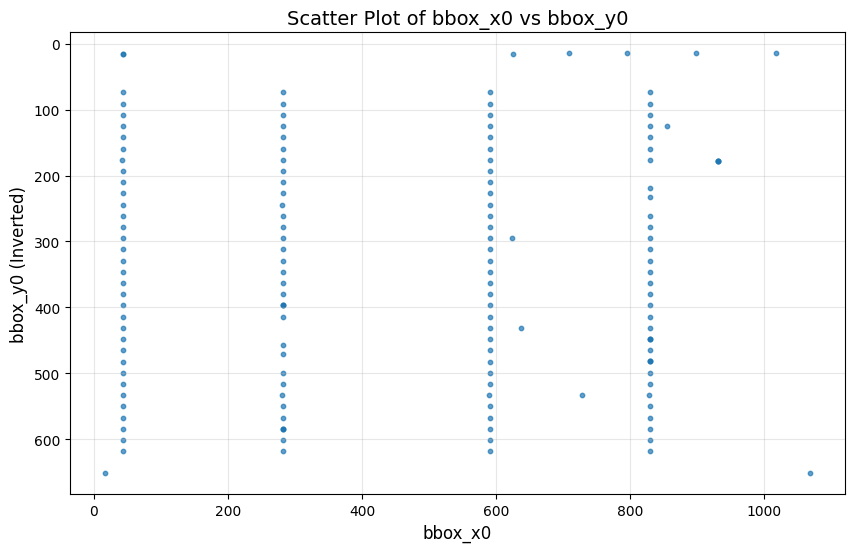

In [8]:
import matplotlib.pyplot as plt

# line_no=1 のデータを抽出
line_1_data = df

# bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
plt.figure(figsize=(10, 6))
plt.scatter(line_1_data['bbox_x0'], line_1_data['bbox_y0'], alpha=0.7, s=10)
plt.title('Scatter Plot of bbox_x0 vs bbox_y0', fontsize=14)
plt.xlabel('bbox_x0', fontsize=12)
plt.ylabel('bbox_y0 (Inverted)', fontsize=12)
plt.gca().invert_yaxis()  # Y軸を上下反転
plt.grid(alpha=0.3)
plt.show()



In [9]:
sorted_y0 = df.sort_values(by='bbox_y0', ascending=False)[['bbox_x0', 'bbox_y0', 'text']]
sorted_y0.head(10)

,bbox_x0,bbox_y0,text
0,1067.396851,651.858154,10
6,17.114500,651.858154,09
152,281.894135,618.158936,ているのは、従業員のエンゲージメントを上げていくことで
117,829.125244,618.158020,創型イノベーションの創出」です。
77,43.942135,618.157532,化学メーカーになる」というレゾナックの長期ビジョンは、総
44,590.300659,618.157288,くの同僚に影響を与えてくれます。
151,281.894135,601.151184,できません。そのために私がとにかく力を入れ、時間を使っ
116,828.649048,601.150269,こうなると、もうシナジーのレベルではありません。まさに「共
76,43.891113,601.149719,れるかは、重要な経営課題です。「世界トップクラスの機能性
43,591.023499,601.149475,みで自律した社員の働き方・考え方は、それぞれの職場で多


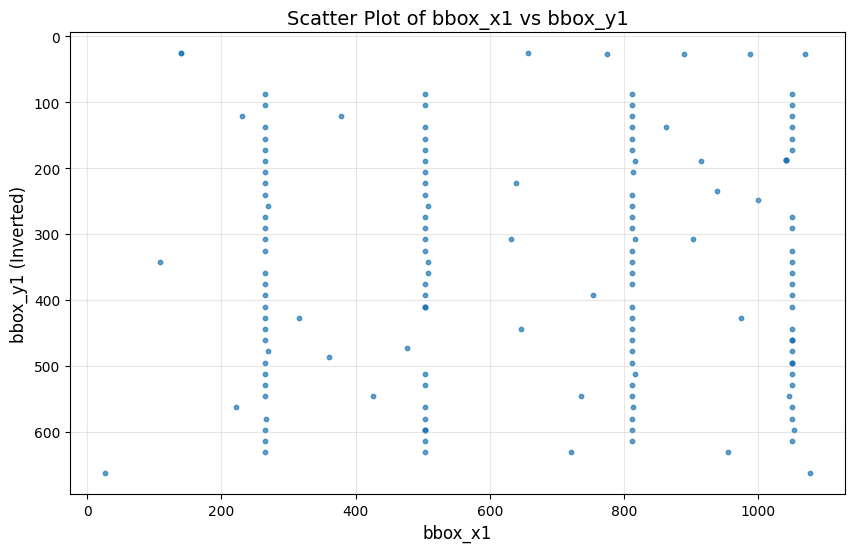

In [10]:
import matplotlib.pyplot as plt

# line_no=1 のデータを抽出
line_1_data = df

# bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
plt.figure(figsize=(10, 6))
plt.scatter(line_1_data['bbox_x1'], line_1_data['bbox_y1'], alpha=0.7, s=10)
plt.title('Scatter Plot of bbox_x1 vs bbox_y1', fontsize=14)
plt.xlabel('bbox_x1', fontsize=12)
plt.ylabel('bbox_y1 (Inverted)', fontsize=12)
plt.gca().invert_yaxis()  # Y軸を上下反転
plt.grid(alpha=0.3)
plt.show()


In [11]:
sorted_y1 = df.sort_values(by='bbox_y1', ascending=True)[['bbox_x0', 'bbox_y0', 'text']]
sorted_y1.head(20)


,bbox_x0,bbox_y0,text
5,625.770630,15.296995,Contents
8,43.827202,15.296995,REPORT 2024
7,43.827202,15.296995,RESONAC
1,1017.863770,14.761236,データセクション
2,897.561646,14.761236,コーポレート・ガバナンス改革
3,795.670532,14.761236,目指すものとクリアすべきもの
4,708.200623,14.761236,レゾナックの自己紹介
9,590.904480,73.907478,す。社長室の椅子に座って眉間にしわを寄せながら電話で発
45,43.942139,73.907722,信じて、より早く、一歩踏み出す。つまり半導体材料において
78,829.132690,73.907967,こうして段階を踏んで、パーパス・バリューを体現する自律


In [12]:
# line_no=1 のデータを抽出し、コピーを作成
line_1_data = df[df['line_no'] == 1].copy()

# bbox_x0 を一定の範囲で丸めてグルーピング
grouping_range = 10  # 10単位でグルーピング
line_1_data['group'] = (line_1_data['bbox_x0'] // grouping_range) * grouping_range

# グループごとに bbox_x0 の最小値と最大値を算出
bbox_x0_groups = line_1_data.groupby('group')['bbox_x0'].agg(['min', 'max', 'count']).reset_index()

# 結果をテキストで出力
#for _, row in bbox_x0_groups.iterrows():
#    print(f"Group: {row['group']} - Min: {row['min']}, Max: {row['max']}, Count: {row['count']}")

# 結果をテキストで出力（小数点2桁で四捨五入）
output_file_path = pdf_path[:len(pdf_path)-4] + "_bbox_x0_counts_page_" + str(page_num) + ".txt"
#output_file_path = 'output.txt'  # 保存するファイル名

with open(output_file_path, 'w', encoding='utf-8') as f:
    print('---- bbox_x0 (line1) counts by range group ----')  # ヘッダーを書き込み
    f.write('---- bbox_x0 (line1) counts by range group ----\n')  # ヘッダーを書き込み
    for _, row in bbox_x0_groups.iterrows():
        min_value = round(row['min'], 2)  # 小数点2桁で四捨五入
        max_value = round(row['max'], 2)  # 小数点2桁で四捨五入
        line = f"Group: {row['group']} - Min: {min_value}, Max: {max_value}, Count: {row['count']}\n"
        print(line.strip())  # コンソールにも出力
        f.write(line)  # ファイルにも書き込み


---- bbox_x0 (line1) counts by range group ----
Group: 10.0 - Min: 17.11, Max: 17.11, Count: 1.0
Group: 40.0 - Min: 42.98, Max: 43.94, Count: 35.0
Group: 280.0 - Min: 281.32, Max: 282.05, Count: 34.0
Group: 590.0 - Min: 590.06, Max: 591.02, Count: 33.0
Group: 820.0 - Min: 828.41, Max: 829.13, Count: 34.0
Group: 1010.0 - Min: 1017.86, Max: 1017.86, Count: 1.0
Group: 1060.0 - Min: 1067.4, Max: 1067.4, Count: 1.0


In [13]:
import numpy as np  # 繰り上げ計算用

# Count > 1 を満たすグループを抽出
filtered_groups = bbox_x0_groups[bbox_x0_groups['count'] > 1]

# 最大値を繰り上げて整数にする
rounded_max_values = np.ceil(filtered_groups['max']).astype(int).tolist()

# 結果を表示
print(rounded_max_values)


[44, 283, 592, 830]


In [14]:
# 最小値を切り下げて整数にする
rounded_min_values = np.floor(bbox_x0_groups['min']).astype(int).tolist()
filtered_rounded_min_values = np.floor(filtered_groups['min']).astype(int).tolist()

# 結果を表示
print(rounded_min_values)
print(filtered_rounded_min_values)

[17, 42, 281, 590, 828, 1017, 1067]
[42, 281, 590, 828]


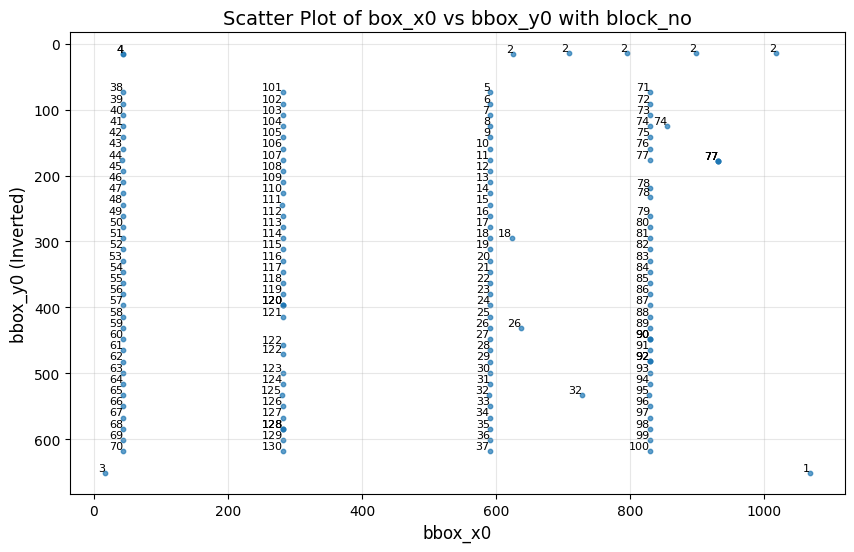

プロットが保存されました: ir/2025/40040_レゾナック・ホールディングス/pdf-sustainability-report-integratedreport-RESONAC24J_spread_block_no_plot_page_6.png


In [15]:
import matplotlib.pyplot as plt

# line_no=1 のデータを抽出
line_1_data = df

# bbox_x0 と bbox_y0 をプロット (Y軸を上下反転)
plt.figure(figsize=(10, 6))
plt.scatter(line_1_data['bbox_x0'], line_1_data['bbox_y0'], alpha=0.7, s=10)

# block_no を各点に表示
for x, y, block_no in zip(line_1_data['bbox_x0'], line_1_data['bbox_y0'], line_1_data['block_no']):
    plt.text(x, y, str(block_no), fontsize=8, ha='right', va='bottom')  # block_no をラベルとして表示

plt.title('Scatter Plot of box_x0 vs bbox_y0 with block_no', fontsize=14)
plt.xlabel('bbox_x0', fontsize=12)
plt.ylabel('bbox_y0 (Inverted)', fontsize=12)
plt.gca().invert_yaxis()  # Y軸を上下反転
plt.grid(alpha=0.3)

# プロットを保存
output_file_path = pdf_path[:len(pdf_path)-4] + "_block_no_plot_page_" + str(page_num) + ".png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')  # DPIを設定して高解像度で保存

# プロットを表示
plt.show()

print(f"プロットが保存されました: {output_file_path}")
